# Ironman triathlon analysis

I have created a web-scraping tool to pull athlete result data from Ironman triathlon events. Using some of this data I'd like to do some simple analysis on the relative distances and finishing times of the three disciplines in triathlon: swim, bike run. In the end, I would like to come up with a 'natural' distance for each disciplines, where each is equally weighted in the event.

## A brief look at finishing times

In [63]:
import pandas as pd
import time

event_folder = 'data/canada140/'
ad = pd.read_csv(event_folder+'data.csv')
ad.head()

,link,name,bib,division,age,state,country,profession,points,overall_rank,...,gender_rank,swim_time,bike_time,run_time,total_time,swim_racetime,bike_racetime,run_racetime,t1_time,t2_time
0,https://www.ironman.com/triathlon/events/ameri...,Raynard Picard,139,35-39,39,CA,MEX,---,5000,1.0,...,1.0,3577.0,17389.0,11612.0,32966.0,3577.0,21193.0,32966.0,227.0,161.0
1,https://www.ironman.com/triathlon/events/ameri...,James Curran,211,35-39,34,Munster,IRL,---,4948,2.0,...,2.0,3820.0,17904.0,11172.0,33224.0,3820.0,21907.0,33224.0,183.0,145.0
2,https://www.ironman.com/triathlon/events/ameri...,Reid Foster,130,30-34,33,OK,USA,---,5000,3.0,...,3.0,3437.0,17605.0,11834.0,33242.0,3437.0,21238.0,33242.0,196.0,170.0
3,https://www.ironman.com/triathlon/events/ameri...,Heather Wurtele,3,PRO,40,BC,CAN,---,5000,4.0,...,1.0,3198.0,18107.0,12084.0,33641.0,3198.0,21429.0,33641.0,124.0,128.0
4,https://www.ironman.com/triathlon/events/ameri...,Karel Sumbal,145,40-44,42,SC,CZE,---,5000,5.0,...,4.0,3510.0,19025.0,11043.0,33913.0,3510.0,22730.0,33913.0,195.0,140.0


In [2]:
print('There are {:d} athlete entries.'.format(len(ad.index)))

There are 1489 athlete entries.


We can see that each athlete entry includes a direct link to it's results page, along with detailed race data. All time-based columns are in units of seconds. First, let's look at the finishing times of all the athletes.

/Users/cpkmanchee/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


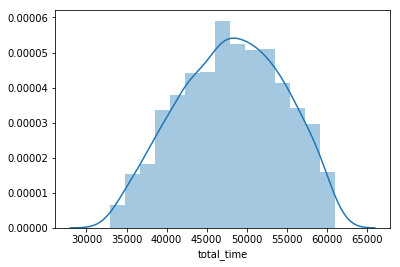

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(ad.total_time.dropna())

Notice the irregular distribution shape and the truncation for long time. This is atleast partially due to the hard time limit of the event (17hrs or 61200s). Additionally, each dicipline has it own cut-off time.

In [73]:
print('The average and median total times are ' + time.strftime('%Hhrs %Mmin %Ss', time.gmtime(np.mean(ad.total_time))) +
     ' and '+ time.strftime('%Hhrs %Mmin %Ss', time.gmtime(np.median(ad.total_time.dropna()))) +
     '. The standard deviation of the distribution is ' +time.strftime('%Hhrs %Mmin %Ss', time.gmtime(np.std(ad.total_time))) + '.') 

The average and median total times are 13hrs 21min 41s and 13hrs 23min 51s. The standard deviation of the distribution is 01hrs 46min 57s.


/Users/cpkmanchee/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


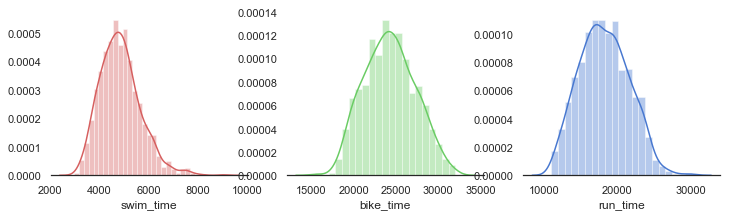

In [103]:
f, ax = plt.subplots(1,3,figsize=(12, 3))
plt.setp(ax, yticks=[])
sns.set(style="white", palette="muted", color_codes=True)
sns.despine(left=True)
sns.distplot(ad.swim_time.dropna(), color='r',ax=ax[0])
sns.distplot(ad.bike_time.dropna(), color='g',ax=ax[1])
sns.distplot(ad.run_time.dropna(), color='b',ax=ax[2])

The event cut-off times for the swim, bike, and run are 2hrs 20min (8400s), 8hrs 10min (29400s), and 6hrs 30min (23400s) respectively. Some individual times may exceed this limit, but the athlete would not be permitted to continue to the next dicipline.

In [54]:
print([(np.mean(time), np.median(time.dropna()), np.std(time), np.std(time)/np.mean(time)) for time in [ad.swim_time,ad.bike_time,ad.run_time]])

[(4839.948738812042, 4765.0, 823.7251282290428, 0.17019294473586197), (24268.259509721047, 24194.0, 3001.649341671252, 0.12368622234606039), (18234.61800699301, 18085.5, 3351.7988083726937, 0.18381513706990038)]


An interesting feature of the plots above is that while the swim times produce the narrowest distribution, they are not the least variable with respect to the mean. The swim time standard deviation is 17.0% of the average swim time, compared to 12.4% for the bike, and 18.4% for the run. The run result at least is expected, since it is the last dicipline of a gruelling event. With the body exhausted it is natural to expect significant variability in finishing times.

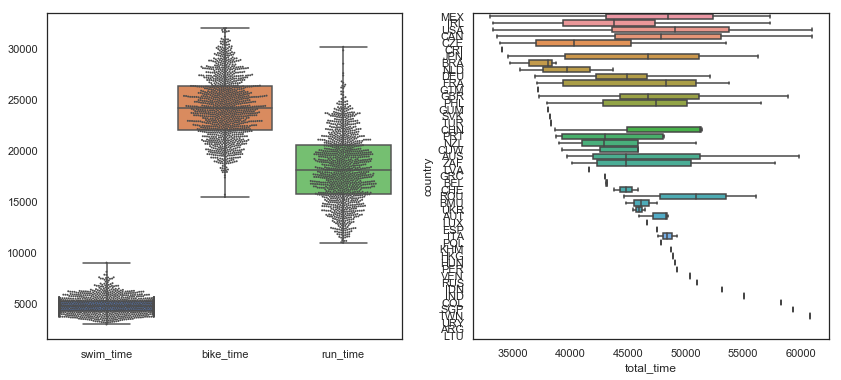

In [104]:
f, ax = plt.subplots(1,2,figsize=(14, 6))
sns.swarmplot(data=ad.iloc[:,12:15],size=2, color=".3", linewidth=0, ax=ax[0])
sns.boxplot(data=ad.iloc[:,12:15], whis="range", ax=ax[0])
sns.boxplot(x='total_time', y='country', data=ad, ax=ax[1])

### A natural triathlon distance

The Ironman triathlon, sometimes referred to as a 140.6, consists of a 3.86km swim, 180.25km bike, and 42.20km run. Added together the event is 226.3km, or 140.6 miles (hence the name). As shown above, the bike portion of the race is heavily weighted, averaging for more than half the total race time. While one could contemplate and debate the merits of this with respect to the sport of triathlon, I am curious what a more evenly weighted race looks like. Presumably there would be less emphasis on the bike, likely being shifted to the swim - but to what extent? 

The total event distance $d_{event}$ is simply the sum of the dicipline distances:
$$
d_{event} = d_{swim} + d_{bike} + d_{run}
$$

In [97]:
d_ims = 3.86
d_imb = 180.25
d_imr = 42.2

226.31

/Users/cpkmanchee/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


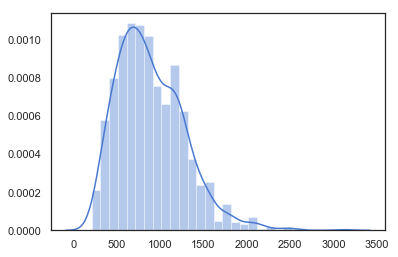

In [111]:
sns.distplot((ad.t1_time+ad.t2_time).dropna())

/Users/cpkmanchee/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


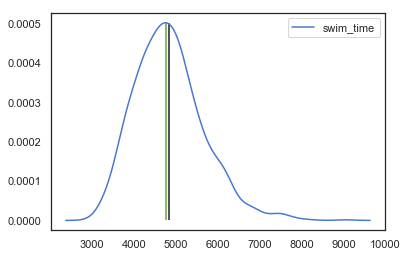

In [153]:
data = ad.swim_time.dropna()
kde = sns.kdeplot(data)
x,y = kde.get_lines()[0].get_data()
imax = np.argmax(y)
plt.vlines([x[imax],np.mean(data),np.median(data)],0,np.max(y), color=['r','k','g'])